In [0]:
# All necessary imports to perform the training
from processedDataHelper import *
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset,DataLoader
from myModelHelper import *
import matplotlib.pyplot as plt
from torch.optim import Optimizer
import  math

In [0]:
# Mount the google drive to save the finally loaded model to drive
from google.colab import files,drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
class SentimentNetwork(nn.Module):
  def __init__(self,vocabulary_size,output_size,embedding_dimension,hidden_dimension,number_of_layers,dropout_probability=0.5):
    super(SentimentNetwork,self).__init__()
    # class data for weight matrix size
    self.output_size=output_size
    self.number_of_layers=number_of_layers
    self.hidden_dimension=hidden_dimension
    # create the embedding layer to reduce dimension 
    # and LSTM layer containing LSTM cells 
    self.embedding=nn.Embedding(vocabulary_size,embedding_dimension)
    self.lstm=nn.LSTM(embedding_dimension,hidden_dimension,number_of_layers,dropout=dropout_probability,batch_first=True)
    
    # Create dropout layer as a regularization method to reduct overfitting
    # this will disable some units in forward pass, thus preventing 
    # a particular set of node's weights getting updated while others remain unused
    self.dropout=nn.Dropout(dropout_probability)
    
    # attach final  linear layer with sigmoid function
    self.finalLayer=nn.Linear(hidden_dimension,output_size)
    self.sigmoid=nn.Sigmoid()
   
  def forward(self,x,hidden):
    batch_size=x.size(0)
    embedding_output=self.embedding(x)
    
    #lstm will take the current input and hidden state as input 
    # and will generate the output to be feed at the linear layer
    lstm_output,hidden=self.lstm(embedding_output,hidden)
    lstm_output=lstm_output.contiguous().view(-1,self.hidden_dimension)
    
    output=self.dropout(lstm_output)
    output=self.finalLayer(output)
    
    #call the sigmoid function on current output of final layer
    sigmoid_output=self.sigmoid(output)
    sigmoid_output=sigmoid_output.view(batch_size,-1)
    #only get the last position output for all batches
    sigmoid_output=sigmoid_output[:,-1]
    
    #current sigmoid output and a hidden state to be fed as input for next pass
    # into the LSTM cells, so that they will be dependent on the previous state
    return sigmoid_output,hidden
  
  def initialize_hidden_state(self,batch_size):
    # At first the hidden state will not hold any information, hence we need to
    # initialize them with zeros
    # Number_of_Layers x Batch_Size x Hidden_Dimension
    weight=next(self.parameters()).data
    if(torch.cuda.is_available()):
      # if GPU is available then initialize the weights parallely
      hidden=(weight.new(self.number_of_layers,batch_size,self.hidden_dimension).zero_().cuda(),weight.new(self.number_of_layers,batch_size,self.hidden_dimension).zero_().cuda())
    else:
      hidden=(weight.new(self.number_of_layers,batch_size,self.hidden_dimension).zero_(),weight.new(self.number_of_layers,batch_size,self.hidden_dimension).zero_())
      
    return hidden

In [0]:
def buildNetwork():
  #Our model parameters
  vocabulary_size=len(vocab_to_int)+1
  output_size=1
  embedding_dimension=400
  hidden_dimension=256
  number_of_layers=3
  
  model=SentimentNetwork(vocabulary_size,output_size,embedding_dimension,hidden_dimension,number_of_layers)
  
  # Alpha value(Step size)
  learning_rate=0.001
  
  # Error calculating formula (Mean Square Error)
  criterion = nn.MSELoss() 
 
  #Adam optimization technique for first-order gradient-based optimization
  #optimizer=AdamOptimizerAlgorithm(model.parameters(),lr=learning_rate)
  optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
  return model,criterion,optimizer

In [0]:
def trainNetwork(model,epochs,print_interval,criterion,optimizer):
  Iteration=[]
  Training_Loss=[]
  Validation_Loss=[]
  
  minimum_validation_loss=np.Inf
  
  # Since each epoch goes over all data and
  # each iteration goes over the data in batches
  count=0
  
  # move model to GPU 
  #model.cuda()
  
  #put the model into training model so that the gradients will 
  # be calculated
  model.train()
  for i in range(epochs):
    # for each epoch perform a forward pass for all batches
    # and around epoch 4 reduce the learning rate
    hidden_state=model.initialize_hidden_state(batch_size)
    
    if(i==3):
      print("\n\nReducing the learning rate!\n")
      optimizer=torch.optim.Adam(model.parameters(),lr=0.0000002)
    
    for inputs,labels in train_loader:
      count+=1
      # move the data to GPU
      inputs,labels=inputs.cuda(),labels.cuda()
      
      #create new variable for hidden state otherwise it will include all
      #pervious states
      hidden_state=tuple([element.data for element in hidden_state])
      
      model.zero_grad()
      
      inputs=inputs.long()
      output,hidden_state=model(inputs,hidden_state)
      
      #calculate the loss to backpropagare to model
      #loss=torch.sqrt(criterion(output.squeeze(),labels.float()))
      loss=criterion(output.squeeze(),labels.float())
      loss.backward()

      
      #nn.utils.clip_grad_norm_(model.parameters(),clip)
      optimizer.step()
      
      if(count%print_interval==0):
        temp_hidden=model.initialize_hidden_state(batch_size)
        temp_losses=[]
        model.eval()
        for inputs,labels in validation_loader:
          temp_hidden=tuple([element.data for element in temp_hidden])
          inputs,labels=inputs.cuda().long(),labels.cuda()
          
          output,temp_hidden=model(inputs,temp_hidden)
          validation_loss=criterion(output.squeeze(),labels.float())
          temp_losses.append(validation_loss.item())
        
        model.train()
        print("Epoch: {}\tIteration: {}\tTraining Loss: {:.7f}\tValidation Loss: {:.7f}".format(
        (i+1),count,loss.item(),np.mean(temp_losses)))
        Iteration.append(count)
        Training_Loss.append(loss.item())
        Validation_Loss.append(np.mean(temp_losses))
        
        if np.mean(temp_losses)<minimum_validation_loss:
            save_checkpoint(model,"checkpoint.pth")
            minimum_validation_loss=np.mean(temp_losses)
            print("Validation loss decreased  hence saving checkpoint successfully")
                  
         

    #Plot the Training and Validation loss
  plt.plot(Iteration,Training_Loss)
  plt.plot(Iteration,Validation_Loss)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.ylim(0.0,1.0)
  plt.legend(['Training Loss','Validation Loss'], loc='upper left')
  plt.show()

In [0]:
def save_checkpoint(model,fileLocation):
  # save the current state_dict which contains all the weights of the network
  torch.save(model.state_dict(),fileLocation)

In [0]:
# To build the network with same architecture and load the checkpoint file
def load_Checkpoint(fileLocation):
  model,criterion,optimizer=buildNetwork()
  model.load_state_dict(torch.load(fileLocation))
  return model,criterion

In [0]:
def checkAccuracy(model,test_loader):
  #move model to GPU
  model.cuda()
  
  test_losses=[]
  correct_prediction=0
  
  #set initial state to zero
  hidden_state=model.initialize_hidden_state(batch_size)
  
  # set the model into evaluation mode, so that we don't need to calculate
  # the gradients
  model.eval()
  
  for inputs,labels in test_loader:
    
    # move the data and labels into GPU
    inputs,labels=inputs.cuda().long(),labels.cuda().long()
    
    output,hidden_state=model(inputs,hidden_state)
    # labels are initially long or int, we need to conver them into float
    # so that loss cab be calculated in float value
    test_loss=criterion(output.squeeze(),labels.float())
    test_losses.append(test_loss.item())
    
    # get the prediction either 1 or 0
    prediction=torch.round(output.squeeze())
    
    correct_tensor=prediction.eq(labels.float().view_as(prediction))   
    correct=np.squeeze(correct_tensor.cpu().numpy())
    correct_prediction+=np.sum(correct)
  
  print("Accuracy: {:.4f}".format(correct_prediction/len(test_loader.dataset)))

In [0]:
# Tokenize passed sentences
def tokenize_sentence(sentence):
  sentence=sentence.lower()
  
  #remove punctuation
  sentence=''.join([letter for letter in sentence if letter not in punctuation])
  
  test_words=sentence.split()
  tokens=[]
  sample=[]
  for word in test_words:
      if word in vocab_to_int:
          sample.append(word)
  tokens.append([vocab_to_int[word] for word in sample])
  return tokens

In [0]:
def predict(model,sentence,sequence_length=200):
  #model.cuda()
  #disable the gradient calculation to speedup the calculation, since we are only using for prediction
  model.eval()
  
  test_ints=tokenize_sentence(sentence)
  features=featuresPadding(test_ints,sequence_length)
  feature_tensor=torch.from_numpy(features)
  batch_size=feature_tensor.size(0)
  
  hidden_state=model.initialize_hidden_state(batch_size)
  feature_tensor=feature_tensor.cuda().long()
  output,hidden_state=model(feature_tensor,hidden_state)
  prediction=torch.round(output.squeeze())
  if(prediction.item()==0):
    print("{:.4f}\t Negative sentence!".format(output.item()))
  else:
    print("{:.4f}\t Positive sentence!".format(output.item()))

In [0]:
#location of preprocessed data
features_location='ProcessedFeatures.npy'
label_location='ProcessedEncodedLabels.npy'
vocab_dict_location='ProcessedVocabToInt.npy'

In [0]:
# Load the preprocessed data, Features=Inputs, Labels=Actual Outputs, VocabToInt=Word to integer mapping
features=loadNumpyArray(features_location)
encoded_labels=loadNumpyArray(label_location)
vocab_to_int=loadDict(vocab_dict_location)

In [0]:
#set the input sequence length to 200
seq_length=200

In [0]:
#Create Train, Test, Validation set with 80% data into train set, and rest 20% divided into equal half for Test and Validation
train_x,train_y,test_x,test_y,val_x,val_y=createTrainTestValidateData(0.8,features,encoded_labels)

In [0]:
# Convert to tensor
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validation_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size=100
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
validation_loader = DataLoader(validation_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [0]:
print("Training: \t",np.shape(train_x))
print("Validation: \t",np.shape(val_x))
print("Test: \t\t",np.shape(test_x))

Training: 	 (40000, 200)
Validation: 	 (5000, 200)
Test: 		 (5000, 200)


In [0]:
#Build Network
model,criterion,optimizer=buildNetwork()

In [0]:
#Move model to GPU, since Google Colab has been used with GPU enabled
model.cuda()

SentimentNetwork(
  (embedding): Embedding(181686, 400)
  (lstm): LSTM(400, 256, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (finalLayer): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [0]:
print_interval = 100
epochs = 20

Epoch: 1	Iteration: 100	Training Loss: 0.6409116	Validation Loss: 0.6310162
Validation loss decreased  hence saving checkpoint successfully
Epoch: 1	Iteration: 200	Training Loss: 0.4938466	Validation Loss: 0.5405232
Validation loss decreased  hence saving checkpoint successfully
Epoch: 1	Iteration: 300	Training Loss: 0.4187748	Validation Loss: 0.4741382
Validation loss decreased  hence saving checkpoint successfully
Epoch: 1	Iteration: 400	Training Loss: 0.5295486	Validation Loss: 0.4390899
Validation loss decreased  hence saving checkpoint successfully
Epoch: 2	Iteration: 500	Training Loss: 0.3579498	Validation Loss: 0.3981382
Validation loss decreased  hence saving checkpoint successfully
Epoch: 2	Iteration: 600	Training Loss: 0.3697390	Validation Loss: 0.3833222
Validation loss decreased  hence saving checkpoint successfully
Epoch: 2	Iteration: 700	Training Loss: 0.2842821	Validation Loss: 0.3537847
Validation loss decreased  hence saving checkpoint successfully
Epoch: 2	Iteration: 

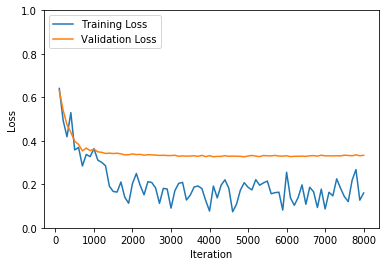



Training Time: 19.56415031750997 minutes


In [0]:
import time
start_time=time.time()
trainNetwork(model,epochs,print_interval,criterion,optimizer)
print("\n\nTraining Time: {} minutes".format((time.time()-start_time)/60))

In [0]:
#Checkpoint Saving Location
fileLocation='/content/drive/My Drive/SEM-IV Project/SentimentAnalysisCheckpoint.pth'

In [0]:
# Accuracy on Test Data for Overfitted model
checkAccuracy(model,test_loader)

Accuracy: 0.8616


In [0]:
# Clear the CUDA Cache to clear GPU Memory
torch.cuda.empty_cache

<function torch.cuda.empty_cache>

In [0]:
# Load the Saved Model 
model,criterion=load_Checkpoint('checkpoint.pth')

In [0]:
# Accuracy on test data for saved model when validatio loss was decreased
checkAccuracy(model,test_loader)

Accuracy: 0.8578


In [0]:
!ls -l

total 334020
-rw-r--r-- 1 root root 297606517 Jun 21 07:32 checkpoint.pth
drwx------ 3 root root      4096 Jun 21 06:25 drive
-rw-r--r-- 1 root root      2865 Jun 21 06:25 myModelHelper.py
-rw-r--r-- 1 root root       275 Jun 21 06:25 processedDataHelper.py
-rw-r--r-- 1 root root    200128 Jun 21 06:25 ProcessedEncodedLabels.npy
-rw-r--r-- 1 root root  40000128 Jun 21 06:32 ProcessedFeatures.npy
-rw-r--r-- 1 root root   4199760 Jun 21 06:26 ProcessedVocabToInt.npy
drwxr-xr-x 2 root root      4096 Jun 21 06:26 __pycache__
drwxr-xr-x 1 root root      4096 Jun 18 16:14 sample_data
